In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

data = pd.read_csv('county_data_without_20_21_22.csv', encoding='cp949', header=None, names=['date', 'number of cold case' ,'county name'])
data

,date,number of cold case,county name
date,county code,number of cold case,county name
2014-01-01,11110,53,Jongno
2014-01-02,11110,1408,Jongno
2014-01-03,11110,1129,Jongno
2014-01-04,11110,890,Jongno
...,...,...,...
2023-09-26,11740,4486,Gangdong
2023-09-27,11740,6009,Gangdong
2023-09-28,11740,1018,Gangdong
2023-09-29,11740,368,Gangdong


In [22]:
print(data.columns)

Index(['date', 'number of cold case', 'county name'], dtype='object')


In [23]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d', errors='coerce')
data.set_index('date', inplace=True)

district_names=data['county name'].unique()
print(district_names)

['county name' 'Jongno' 'Jung' 'Yongsan' 'Seongdong' 'Gwangjin'
 'Dongdaemun' 'Jungnang' 'Seongbuk' 'Gangbuk' 'Dobong' 'Nowon' 'Eunpyeong'
 'Seodaemun' 'Mapo' 'Yangcheon' 'Gangseo' 'Guro' 'Geumcheon'
 'Yeongdeungpo' 'Dongjak' 'Gwanak' 'Seocho' 'Gangnam' 'Songpa' 'Gangdong']


1.LSTM 기본 코드
과거 30일 데이터로 내일 확진자 수 예측

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 데이터 불러오기
data = pd.read_csv('county_data_without_20_21_22.csv', encoding='cp949')

# 날짜를 인덱스로 설정
data['날짜'] = pd.to_datetime(data['날짜'])
data.set_index('날짜', inplace=True)

# 특정 시군구에 대한 데이터만 선택 (예: 'Jongno')
district_data = data[data['시군구명_영문'] == 'Jongno']

# '발생건수(건)' 열만 사용하여 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(district_data['발생건수(건)'].values.reshape(-1, 1))

# 시계열 윈도우 생성 함수
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# 30일 간의 데이터를 기반으로 예측 (look_back=30)
look_back = 30
X, Y = create_dataset(scaled_data, look_back)

# 입력 데이터를 LSTM 모델에 맞게 3차원 배열로 변환
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(X, Y, epochs=100, batch_size=32)

# 예측 (가장 최근의 데이터를 사용해 미래 예측)
predicted_cases = model.predict(X[-1].reshape(1, look_back, 1))
predicted_cases = scaler.inverse_transform(predicted_cases)

print("예측된 감기 확진자 수:", predicted_cases)


Epoch 1/100


c:\Users\rlawn\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0362
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0210
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0210
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0198
Epoch 5/100
43/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0208

KeyboardInterrupt: 

2.LSTM
구 별로 필터링, 모든 데이터 사용해 예측, 서버 시간 연동해 24시간마다 재학습 후 결과 도출

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
import time

# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(file_path, district):
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['date'])  # 날짜 컬럼 이름에 맞게 수정
    data = data[data['district'] == district]  # 구 이름에 따라 필터링
    data = data.sort_values('date').reset_index(drop=True)
    data.fillna(data.mean(), inplace=True)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['value'].values.reshape(-1, 1))  # 'value'는 예측할 값의 컬럼 이름
    return scaled_data, scaler

# 시퀀스 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)):
        a = data[:i + 1, 0]  # 현재 인덱스까지 모든 데이터를 사용
        X.append(a)
        if i + 1 < len(data):
            y.append(data[i + 1, 0])  # 다음 날 값을 예측
    return np.array(X), np.array(y)

# 모델 생성 및 학습 함수
def create_and_train_model(X, y):
    X = [np.pad(x, (0, max(0, X.shape[1] - len(x))), 'constant', constant_values=0) for x in X]
    X = np.array(X).reshape(len(X), -1, 1)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=100, batch_size=32)
    
    return model

# 예측 함수
def make_prediction(model, last_data):
    last_data = last_data.reshape(1, 1, 1)  # LSTM 입력 형식으로 변환
    predicted_value = model.predict(last_data)
    return predicted_value

# 데이터 추가 함수 (가정: 새 데이터는 CSV 파일에 저장)
def update_data(file_path, district):
    new_data = {
        'date': [datetime.now() - timedelta(days=1)],  # 어제 날짜
        'district': [district],  # 구 이름
        'value': [np.random.rand()]  # 임의의 값, 실제 데이터를 업데이트해야 함
    }
    new_data_df = pd.DataFrame(new_data)
    
    # 기존 CSV 파일에 새로운 데이터 추가
    new_data_df.to_csv(file_path, mode='a', header=False, index=False)

# 메인 루프
def main():
    file_path = 'data.csv'  # 데이터 파일 경로
    districts = ['구이름1', '구이름2', ..., '구이름25']  # 구 이름 리스트
    
    while True:
        for district in districts:
            # 1. 데이터 준비
            scaled_data, scaler = load_and_preprocess_data(file_path, district)
            X, y = create_dataset(scaled_data, time_step=1)

            # 2. 모델 생성 및 학습
            model = create_and_train_model(X, y)

            # 3. 예측 수행
            last_data = scaled_data[-1:]  # 마지막 데이터
            predicted_value = make_prediction(model, last_data)
            predicted_value = scaler.inverse_transform(predicted_value)
            print(f'Predicted Value for the next day in {district}: {predicted_value[0][0]}')

            # 4. 데이터 업데이트
            update_data(file_path, district)

        # 5. 하루 대기 (24시간)
        time.sleep(86400)  # 86400초 = 24시간

# 메인 함수 실행
if __name__ == "__main__":
    main()


2-1. LSTM
날짜에 맞도록 2번 코드 수정


In [ ]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(file_path, county_name):
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['county name'] == county_name]  # 구 이름 필터링
    data = data.sort_values('date').reset_index(drop=True)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['number of cold case'].values.reshape(-1, 1))
    return scaled_data, scaler, data['date']

# 시퀀스 생성 함수 (특정 날짜까지의 데이터를 사용해 예측)
def create_dataset(data, date_data, target_date, time_step=1):
    X, y = [], []
    
    # target_date까지의 데이터를 기준으로 시퀀스 생성
    for i in range(len(data)):
        if date_data[i] == target_date:
            a = data[:i + 1, 0]  # target_date까지의 데이터를 시퀀스로 사용
            X.append(a)
            break
    
    return np.array(X)

# 모델 생성 및 학습 함수
def create_and_train_model(X, y):
    X = [np.pad(x, (0, max(0, X.shape[1] - len(x))), 'constant', constant_values=0) for x in X]
    X = np.array(X).reshape(len(X), -1, 1)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=100, batch_size=32)
    
    return model

# 특정 날짜의 예측 수행 함수
def predict_for_date(model, target_date, scaled_data, date_data):
    # target_date까지의 데이터를 이용해 시퀀스 생성
    X = create_dataset(scaled_data, date_data, target_date)
    X = np.pad(X, (0, max(0, 1 - len(X[0]))), 'constant').reshape(1, -1, 1)  # LSTM 입력 형식으로 변환
    predicted_value = model.predict(X)
    return predicted_value

# 서버 시간을 기준으로 예측할 날짜 추출
def get_server_date():
    server_date = datetime.now().strftime('%Y-%m-%d')
    return pd.to_datetime(server_date)

# 메인 함수
def main():
    file_path = 'data.csv'  # 데이터 파일 경로
    counties = ['Jongno', 'Gangnam', 'Gangdong', ...]  # 구 리스트
    target_date = get_server_date()  # 서버 시간을 기준으로 날짜 설정

    for county_name in counties:
        # 1. 데이터 로드 및 전처리
        scaled_data, scaler, date_data = load_and_preprocess_data(file_path, county_name)

        # 2. 예측 모델 생성 및 학습 (여기서는 예시로 하나의 구를 학습시킴)
        # 실제 예측을 위해서는 전체 데이터를 학습 후 모델을 저장하거나 미리 학습된 모델을 사용
        # create_and_train_model()를 사용해 학습을 진행
        # 예를 들어 y 값이 없는 경우, 기존 학습된 모델을 로드하도록 추가 가능

        # 3. 서버 시간에 맞는 날짜의 예측 수행
        predicted_value = predict_for_date(model, target_date, scaled_data, date_data)
        predicted_value = scaler.inverse_transform(predicted_value)
        
        print(f'Predicted Value for {target_date.date()} in {county_name}: {predicted_value[0][0]}')

# 메인 함수 실행
if __name__ == "__main__":
    main()


3. sequential
split the data(validation, test, train)
손실함수 시각화(25개)

Epoch 1/100


C:\Users\rlawn\AppData\Local\Temp\ipykernel_4488\2167542630.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['number of cold case'].fillna(0, inplace=True)
C:\Users\rlawn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0382 - val_loss: 0.0215
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.0213
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207 - val_loss: 0.0205
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.0206
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_loss: 0.0192
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - val_loss: 0.0185
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_loss: 0.0183
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_loss: 0.0172
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.0176
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207 - val_loss: 0.0166
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197 - val_l

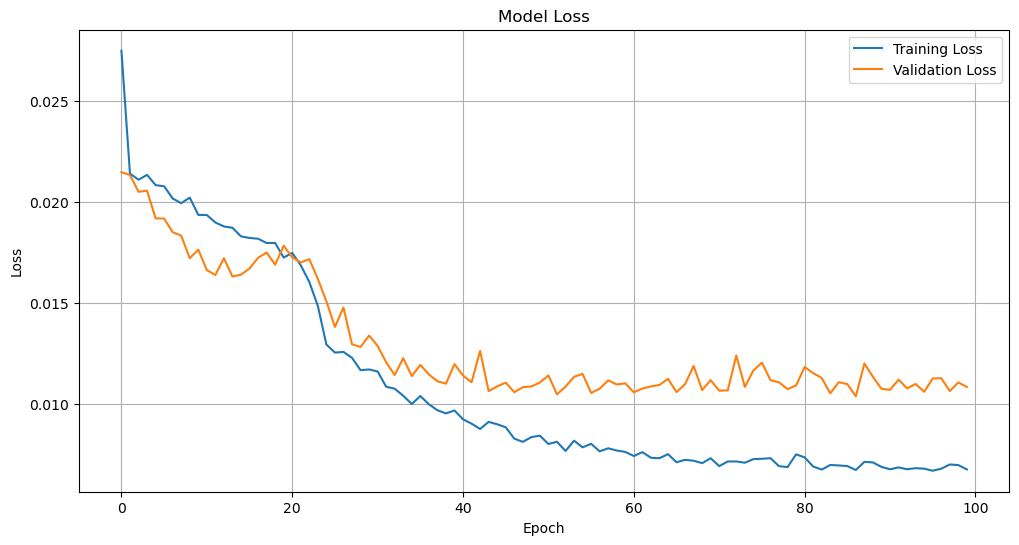

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097
Test Loss for Jongno: 0.007890166714787483
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicted Value for 2024-10-09 in Jongno: 801.8748168945312
Epoch 1/100


C:\Users\rlawn\AppData\Local\Temp\ipykernel_4488\2167542630.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['number of cold case'].fillna(0, inplace=True)
C:\Users\rlawn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0448 - val_loss: 0.0245
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - val_loss: 0.0244
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.0222
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0227
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - val_loss: 0.0221
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - val_loss: 0.0217
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_loss: 0.0207
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - val_loss: 0.0203
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - val_loss: 0.0193
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - val_loss: 0.0189
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - val_loss: 0.0189
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0214 - val_lo

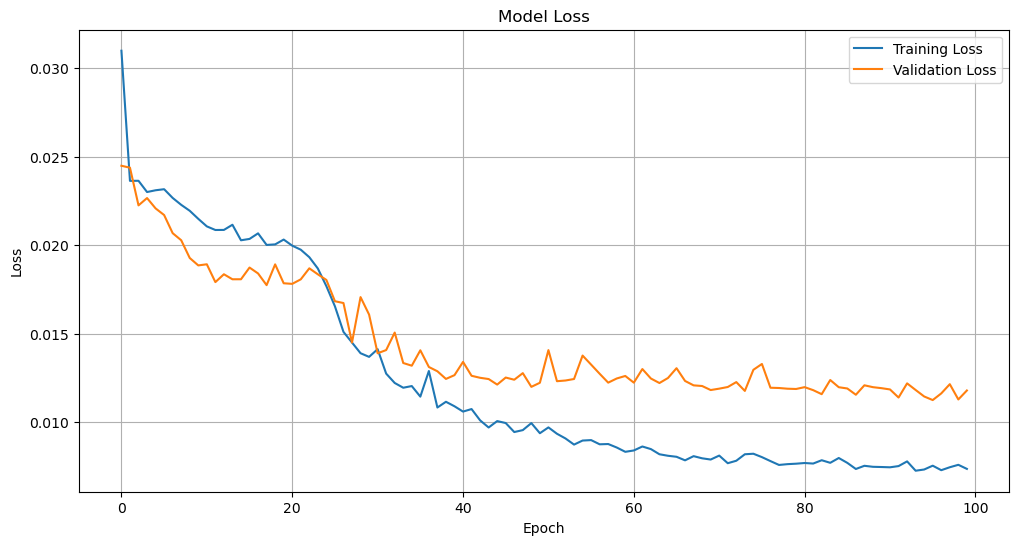

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0109 
Test Loss for Jung: 0.009127391502261162
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicted Value for 2024-10-09 in Jung: 746.4004516601562
Epoch 1/100


C:\Users\rlawn\AppData\Local\Temp\ipykernel_4488\2167542630.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['number of cold case'].fillna(0, inplace=True)
C:\Users\rlawn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0475 - val_loss: 0.0254
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239 - val_loss: 0.0262
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0238 - val_loss: 0.0235
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 - val_loss: 0.0243
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - val_loss: 0.0228
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.0225
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - val_loss: 0.0216
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.0226
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - val_loss: 0.0209
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - val_loss: 0.0209
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.0208
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_lo

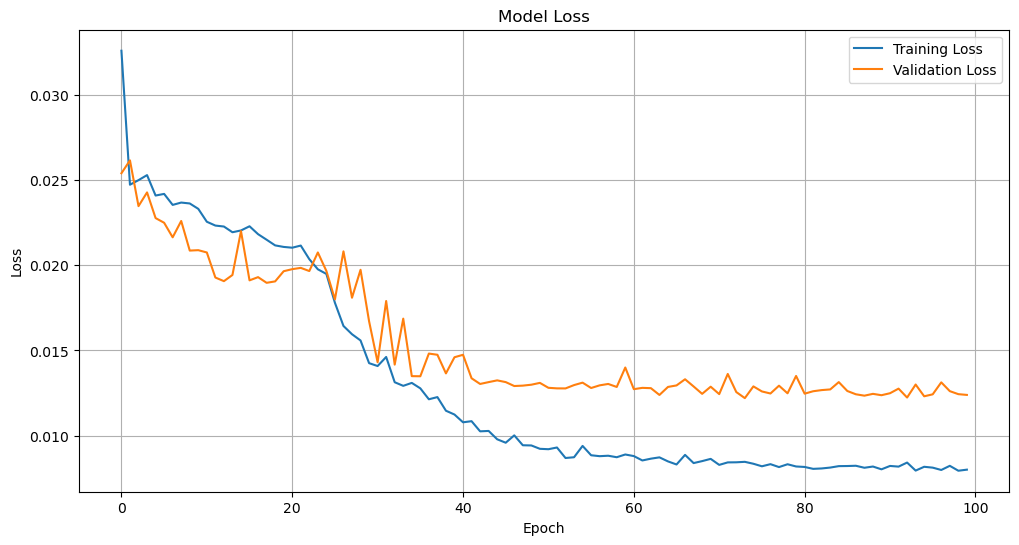

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 
Test Loss for Yongsan: 0.009016908705234528
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicted Value for 2024-10-09 in Yongsan: 1413.7154541015625
Epoch 1/100


C:\Users\rlawn\AppData\Local\Temp\ipykernel_4488\2167542630.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['number of cold case'].fillna(0, inplace=True)
C:\Users\rlawn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0526 - val_loss: 0.0270
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 - val_loss: 0.0231
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - val_loss: 0.0229
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - val_loss: 0.0228
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0225
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - val_loss: 0.0235
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0221
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.0215
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_loss: 0.0214
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - val_loss: 0.0213
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220 - val_loss: 0.0206
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - val_lo

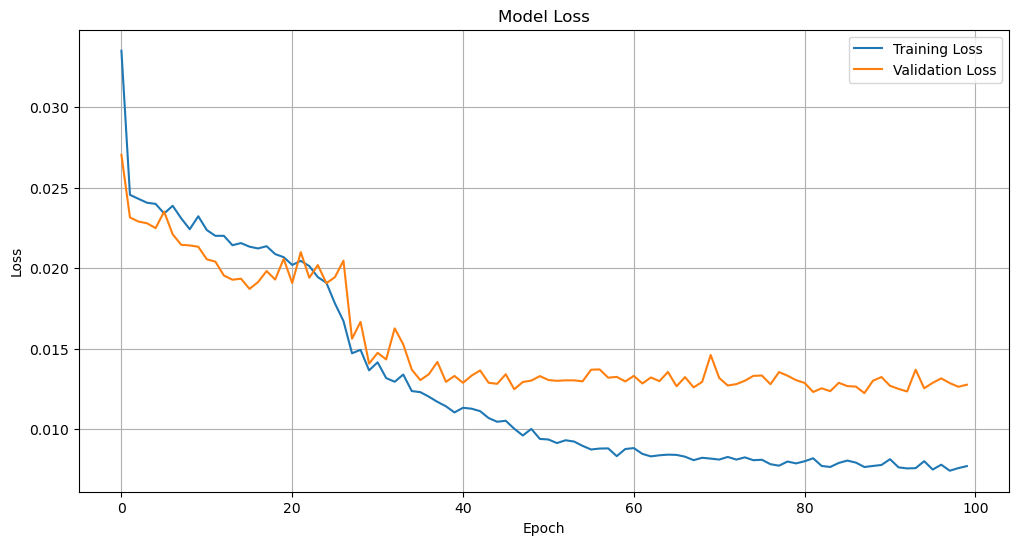

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112  
Test Loss for Seongdong: 0.0095256632193923
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predicted Value for 2024-10-09 in Seongdong: 2155.35107421875
Epoch 1/100


C:\Users\rlawn\AppData\Local\Temp\ipykernel_4488\2167542630.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['number of cold case'].fillna(0, inplace=True)
C:\Users\rlawn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0517 - val_loss: 0.0254
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 - val_loss: 0.0246
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252 - val_loss: 0.0235
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0250 - val_loss: 0.0247
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.0238
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0234
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - val_loss: 0.0229
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0250 - val_loss: 0.0223
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - val_loss: 0.0217
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0229 - val_loss: 0.0207
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - val_loss: 0.0208
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - val_lo

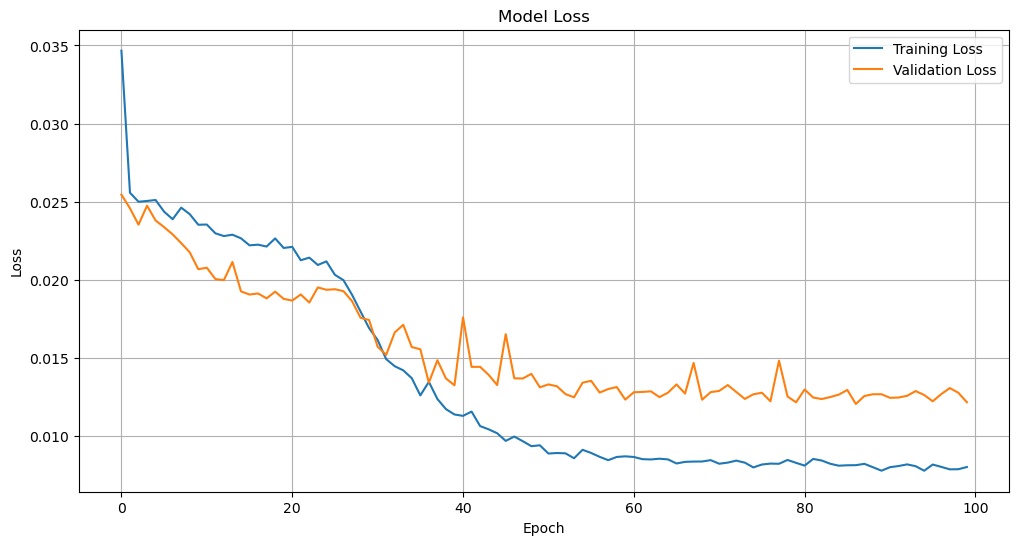

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107 
Test Loss for Gwangjin: 0.009285472333431244
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predicted Value for 2024-10-09 in Gwangjin: 2394.41845703125
Epoch 1/100


C:\Users\rlawn\AppData\Local\Temp\ipykernel_4488\2167542630.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['number of cold case'].fillna(0, inplace=True)
C:\Users\rlawn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0538 - val_loss: 0.0246
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259 - val_loss: 0.0320
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270 - val_loss: 0.0242
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0242 - val_loss: 0.0235
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - val_loss: 0.0236
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0251 - val_loss: 0.0229
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237 - val_loss: 0.0250
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.0224
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0238 - val_loss: 0.0222
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - val_loss: 0.0215
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.0207
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_lo

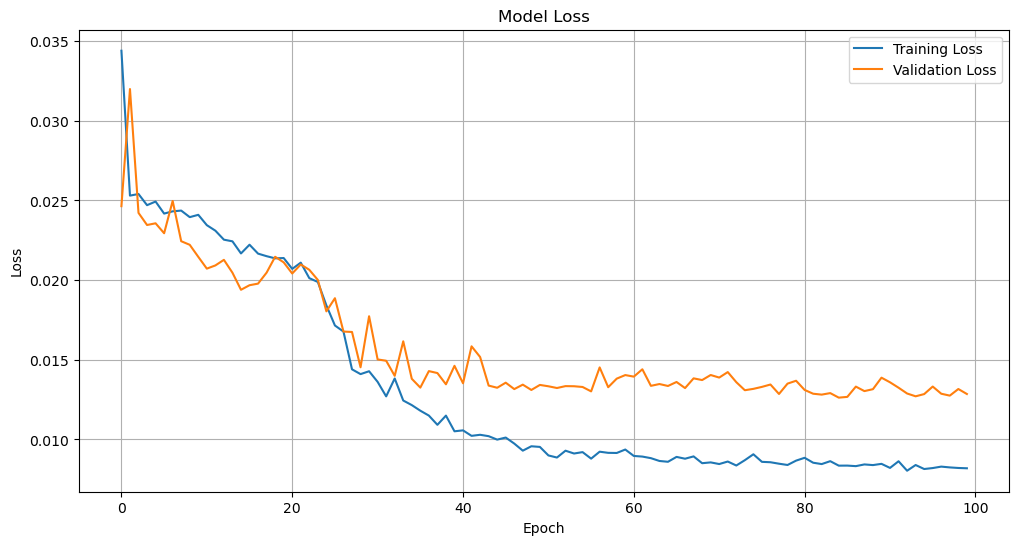

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0107
Test Loss for Dongdaemun: 0.00904706958681345
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicted Value for 2024-10-09 in Dongdaemun: 2360.780029296875
Epoch 1/100


C:\Users\rlawn\AppData\Local\Temp\ipykernel_4488\2167542630.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['number of cold case'].fillna(0, inplace=True)
C:\Users\rlawn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0452 - val_loss: 0.0229
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - val_loss: 0.0226
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 - val_loss: 0.0223
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.0219
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - val_loss: 0.0211
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0237 - val_loss: 0.0209
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - val_loss: 0.0212
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - val_loss: 0.0210
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220 - val_loss: 0.0209
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0223 - val_loss: 0.0206
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220 - val_loss: 0.0201
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_lo

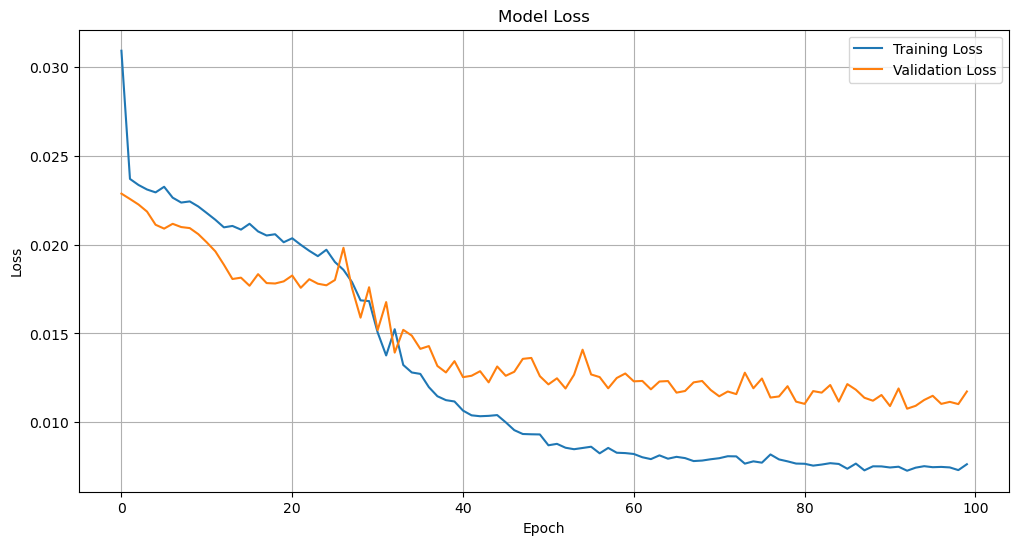

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0105
Test Loss for Jungnang: 0.009110496379435062
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predicted Value for 2024-10-09 in Jungnang: 2871.558349609375
Epoch 1/100


C:\Users\rlawn\AppData\Local\Temp\ipykernel_4488\2167542630.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['number of cold case'].fillna(0, inplace=True)
C:\Users\rlawn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0468 - val_loss: 0.0257
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0258 - val_loss: 0.0243
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0252 - val_loss: 0.0240
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0259 - val_loss: 0.0234
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.0229
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - val_loss: 0.0225
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0227 - val_loss: 0.0233
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0233 - val_loss: 0.0217
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.0211
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0241 - val_loss: 0.0210
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231 - val_loss: 0.0218
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0226 - val_lo

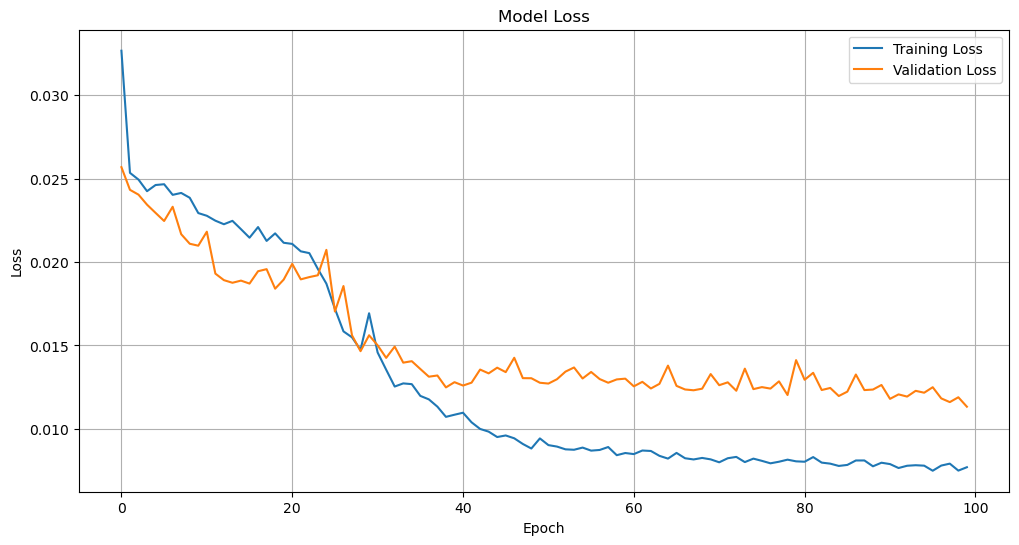

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095
Test Loss for Seongbuk: 0.00831940583884716
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Predicted Value for 2024-10-09 in Seongbuk: 3059.61474609375
Epoch 1/100


C:\Users\rlawn\AppData\Local\Temp\ipykernel_4488\2167542630.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['number of cold case'].fillna(0, inplace=True)
C:\Users\rlawn\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0383 - val_loss: 0.0201
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202 - val_loss: 0.0195
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195 - val_loss: 0.0193
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0205 - val_loss: 0.0187
Epoch 5/100
43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184

KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from datetime import datetime

# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(file_path, county_name):
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['date'])
    data['number of cold case'].fillna(0, inplace=True)
    data = data[data['county name'] == county_name]
    data = data.sort_values('date').reset_index(drop=True)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['number of cold case'].values.reshape(-1, 1))
    return scaled_data, scaler

# 시퀀스 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)


# 모델 생성 및 학습 함수
def create_and_train_model(X_train, y_train, X_val, y_val):
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))
    return model, history

# 정확도 및 손실 시각화 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

# 특정 날짜의 예측 수행 함수
def predict_for_date(model, target_date, scaled_data):
    time_step = 10  # 예를 들어 10일을 기준으로
    X = create_dataset(scaled_data, time_step)[0]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    # target_date의 예측 수행
    predicted_value = model.predict(X)
    return predicted_value

# 서버 시간을 기준으로 예측할 날짜 추출
def get_server_date():
    server_date = datetime.now().strftime('%Y-%m-%d')
    return pd.to_datetime(server_date)

# 메인 함수
def main():
    file_path = 'county_data_without_20_21_22.csv'  # 데이터 파일 경로
    counties = ['Jongno', 'Jung', 'Yongsan', 'Seongdong', 'Gwangjin', 'Dongdaemun', 'Jungnang', 'Seongbuk', 'Gangbuk', 'Dobong', 'Nowon', 'Eunpyeong', 'Seodaemun', 'Mapo', 'Yangcheon', 'Gangseo', 'Guro',  'Geumcheon', 'Yeongdeungpo', 'Dongjak', 'Gwanak', 'Seocho', 'Songpa', 'Gangnam', 'Gangdong']  # 구 리스트
    
    for county_name in counties:
        # 1. 데이터 로드 및 전처리
        scaled_data, scaler = load_and_preprocess_data(file_path, county_name)

        # 2. 데이터 분할
        time_step = 10  # 과거 10일 기준
        X, y = create_dataset(scaled_data, time_step)
        
        # 훈련, 검증, 테스트 세트 분할
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        # 3. 모델 생성 및 학습
        model, history = create_and_train_model(X_train, y_train, X_val, y_val)

        # 4. 손실 시각화
        plot_loss(history)

        # 5. 테스트 세트에서 성능 평가
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        test_loss = model.evaluate(X_test, y_test)
        print(f'Test Loss for {county_name}: {test_loss}')

        # 6. 서버 시간에 맞는 날짜의 예측 수행
        target_date = get_server_date()
        predicted_value = predict_for_date(model, target_date, scaled_data)
        predicted_value = scaler.inverse_transform(predicted_value)
        
        print(f'Predicted Value for {target_date.date()} in {county_name}: {predicted_value[0][0]}')

# 메인 함수 실행
if __name__ == "__main__":
    main()


3-1. sequential
손실함수 그래프 1개-선 25개

In [6]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(file_path, county_name):
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['county name'] == county_name]  # 구 이름 필터링
    data = data.sort_values('date').reset_index(drop=True)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['number of cold case'].values.reshape(-1, 1))
    return scaled_data, scaler, data['date']

# 시퀀스 생성 함수 (특정 날짜까지의 데이터를 사용해 예측)
def create_dataset(data, date_data, target_date, time_step=1):
    X, y = [], []
    
    # target_date까지의 데이터를 기준으로 시퀀스 생성
    for i in range(len(data)):
        if date_data[i] == target_date:
            a = data[:i + 1, 0]  # target_date까지의 데이터를 시퀀스로 사용
            X.append(a)
            break
    
    return np.array(X)

# 모델 생성 및 학습 함수
def create_and_train_model(X, y):
    X = [np.pad(x, (0, max(0, X.shape[1] - len(x))), 'constant', constant_values=0) for x in X]
    X = np.array(X).reshape(len(X), -1, 1)

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    history = model.fit(X, y, epochs=100, batch_size=32, verbose=0)  # verbose=0으로 학습 출력 생략
    return model, history

# 특정 날짜의 예측 수행 함수
def predict_for_date(model, target_date, scaled_data, date_data):
    # target_date까지의 데이터를 이용해 시퀀스 생성
    X = create_dataset(scaled_data, date_data, target_date)
    X = np.pad(X, (0, max(0, 1 - len(X[0]))), 'constant').reshape(1, -1, 1)  # LSTM 입력 형식으로 변환
    predicted_value = model.predict(X)
    return predicted_value

# 서버 시간을 기준으로 예측할 날짜 추출
def get_server_date():
    server_date = datetime.now().strftime('%Y-%m-%d')
    return pd.to_datetime(server_date)

# 메인 함수
def main():
    file_path = 'county_data_without_20_21_22.csv'  # 데이터 파일 경로
    counties = ['Jongno', 'Jung', 'Yongsan', 'Seongdong', 'Gwangjin', 'Dongdaemun', 'Jungnang', 'Seongbuk', 'Gangbuk', 'Dobong', 'Nowon', 'Eunpyeong', 'Seodaemun', 'Mapo', 'Yangcheon', 'Gangseo', 'Guro',  'Geumcheon', 'Yeongdeungpo', 'Dongjak', 'Gwanak', 'Seocho', 'Songpa', 'Gangnam', 'Gangdong']  # 구 리스트
    target_date = get_server_date()  # 서버 시간을 기준으로 날짜 설정

    plt.figure(figsize=(12, 6))  # 그래프 크기 설정
    for county_name in counties:
        # 1. 데이터 로드 및 전처리
        scaled_data, scaler, date_data = load_and_preprocess_data(file_path, county_name)

        # 2. 예측 모델 생성 및 학습
        # y 값을 생성하기 위해 시퀀스 생성
        y = scaled_data[1:]  # 예측할 값은 다음 시점의 값
        X = create_dataset(scaled_data, date_data, target_date)

        model, history = create_and_train_model(X, y)

        # 3. 손실 값 시각화
        plt.plot(history.history['loss'], label=f'Loss for {county_name}')

        # 4. 서버 시간에 맞는 날짜의 예측 수행
        predicted_value = predict_for_date(model, target_date, scaled_data, date_data)
        predicted_value = scaler.inverse_transform(predicted_value)
        
        print(f'Predicted Value for {target_date.date()} in {county_name}: {predicted_value[0][0]}')

    # 그래프 제목 및 레이블 설정
    plt.title('Loss for Each County')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')  # 범례 위치 조정
    plt.grid()  # 격자 추가
    plt.show()

# 메인 함수 실행
if __name__ == "__main__":
    main()


ValueError: cannot reshape array of size 0 into shape (0,newaxis,1)

<Figure size 1200x600 with 0 Axes>